# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
train_df = pd.read_csv('training_data_02_01.csv')
test_df = pd.read_csv('testing_data_cropped.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Training columns: {list(train_df.columns)}")

Training data shape: (4557000, 32)
Test data shape: (2235, 25)
Training columns: ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'GameUrl', 'OpeningTags', 'success_prob_rapid_1050', 'success_prob_rapid_1150', 'success_prob_rapid_1250', 'success_prob_rapid_1350', 'success_prob_rapid_1450', 'success_prob_rapid_1550', 'success_prob_rapid_1650', 'success_prob_rapid_1750', 'success_prob_rapid_1850', 'success_prob_rapid_1950', 'success_prob_rapid_2050', 'success_prob_blitz_1050', 'success_prob_blitz_1150', 'success_prob_blitz_1250', 'success_prob_blitz_1350', 'success_prob_blitz_1450', 'success_prob_blitz_1550', 'success_prob_blitz_1650', 'success_prob_blitz_1750', 'success_prob_blitz_1850', 'success_prob_blitz_1950', 'success_prob_blitz_2050']


Missing values in training data:
PuzzleId                         0
FEN                              0
Moves                            0
Rating                           0
RatingDeviation                  0
Popularity                       0
NbPlays                          0
Themes                           0
GameUrl                          0
OpeningTags                3576326
success_prob_rapid_1050          0
success_prob_rapid_1150          0
success_prob_rapid_1250          0
success_prob_rapid_1350          0
success_prob_rapid_1450          0
success_prob_rapid_1550          0
success_prob_rapid_1650          0
success_prob_rapid_1750          0
success_prob_rapid_1850          0
success_prob_rapid_1950          0
success_prob_rapid_2050          0
success_prob_blitz_1050          0
success_prob_blitz_1150          0
success_prob_blitz_1250          0
success_prob_blitz_1350          0
success_prob_blitz_1450          0
success_prob_blitz_1550          0
success_prob_blitz_165

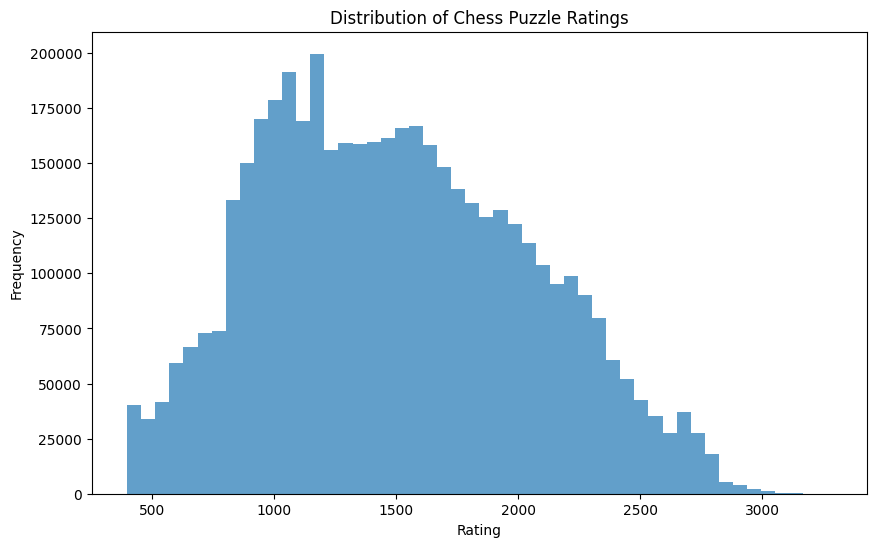

Rating statistics:
count    4.557000e+06
mean     1.500559e+03
std      5.441784e+02
min      3.990000e+02
25%      1.071000e+03
50%      1.461000e+03
75%      1.903000e+03
max      3.284000e+03
Name: Rating, dtype: float64


In [3]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

# Examine target variable distribution
plt.figure(figsize=(10, 6))
plt.hist(train_df['Rating'], bins=50, alpha=0.7)
plt.title('Distribution of Chess Puzzle Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

print(f"Rating statistics:")
print(train_df['Rating'].describe())

# 2. Data Preprocessing

In [4]:
def preprocess_basic_data(df):
    """Basic preprocessing for missing values and data types"""
    # Handle missing values
    df = df.copy()
    
    # Fill missing success probabilities with 0
    success_cols = [col for col in df.columns if 'success_prob' in col]
    df[success_cols] = df[success_cols].fillna(0)
    
    # Fill missing numerical columns
    numerical_cols = ['RatingDeviation', 'Popularity', 'NbPlays']
    for col in numerical_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # Fill missing text columns
    text_cols = ['Themes', 'OpeningTags']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].fillna('')
    
    return df

# Apply preprocessing
train_clean = preprocess_basic_data(train_df)
test_clean = preprocess_basic_data(test_df)

In [6]:
# Save cleaned data
train_clean.to_csv('train_cleaned.csv', index=False)
test_clean.to_csv('test_cleaned.csv', index=False)
print("Cleaned data saved!")

Cleaned data saved!


# 3. Baseline Model

In [8]:
def create_quick_features(df):
    """Create quick features for immediate baseline"""
    features = pd.DataFrame()
    features['PuzzleId'] = df['PuzzleId']
    
    # Success probability features (MOST IMPORTANT!)
    success_cols = [col for col in df.columns if 'success_prob' in col]
    for col in success_cols:
        features[col] = df[col]
    
    # Success probability statistics
    rapid_cols = [col for col in success_cols if 'rapid' in col]
    blitz_cols = [col for col in success_cols if 'blitz' in col]
    
    if rapid_cols:
        features['rapid_mean'] = df[rapid_cols].mean(axis=1)
        features['rapid_std'] = df[rapid_cols].std(axis=1).fillna(0)
        features['rapid_min'] = df[rapid_cols].min(axis=1)
        features['rapid_max'] = df[rapid_cols].max(axis=1)
    
    if blitz_cols:
        features['blitz_mean'] = df[blitz_cols].mean(axis=1)
        features['blitz_std'] = df[blitz_cols].std(axis=1).fillna(0)
        features['blitz_min'] = df[blitz_cols].min(axis=1)
        features['blitz_max'] = df[blitz_cols].max(axis=1)
    
    # Basic move features
    features['move_count'] = df['Moves'].fillna('').str.split().str.len()
    features['has_captures'] = df['Moves'].fillna('').str.contains('x').astype(int)
    features['has_checks'] = df['Moves'].fillna('').str.contains(r'\+').astype(int)
    
    # Metadata features (if available)
    if 'NbPlays' in df.columns:
        features['nb_plays'] = df['NbPlays']
        features['log_nb_plays'] = np.log1p(df['NbPlays'])
    else:
        features['nb_plays'] = 0
        features['log_nb_plays'] = 0
    
    if 'Popularity' in df.columns:
        features['popularity'] = df['Popularity']
    else:
        features['popularity'] = 0
    
    return features

# Create quick features
train_features = create_quick_features(train_clean)
test_features = create_quick_features(test_clean)

print(f"Created {len(train_features.columns)-1} features")

Created 36 features


## 3.1 Train Quick Baseline

this model RandomForest took ages, so i quit it, was a bad try. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare data
X = train_features.drop(['PuzzleId'], axis=1)
y = train_clean['Rating']

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)

print(f"Validation MSE: {val_mse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import time

In [21]:
def ultra_fast_xgboost_baseline(train_features, train_clean, sample_size=100000):
    print(f"Ultra-fast XGBoost baseline with {sample_size} samples...")
    
    # Sample the data
    sample_indices = np.random.choice(len(train_features), size=min(sample_size, len(train_features)), replace=False)
    X_sample = train_features.drop(['PuzzleId'], axis=1).iloc[sample_indices]
    y_sample = train_clean['Rating'].iloc[sample_indices]
    
    # Split for validation
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
    
    # XGBoost 
    start_time = time.time()
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=0  # Suppress output
    )
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"XGBoost training completed in {training_time:.2f} seconds")
    
    # Evaluate
    val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_pred)
    val_rmse = np.sqrt(val_mse)
    print(f"Validation MSE: {val_mse:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_sample.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    return model, feature_importance

# Actually call the function here!
model, feature_importance = ultra_fast_xgboost_baseline(train_features, train_clean)

Ultra-fast XGBoost baseline with 100000 samples...
XGBoost training completed in 0.45 seconds
Validation MSE: 113602.87
Validation RMSE: 337.05

Top 10 Most Important Features:
                    feature  importance
1   success_prob_rapid_1150    0.591820
0   success_prob_rapid_1050    0.132778
11  success_prob_blitz_1050    0.110418
30               move_count    0.035618
24                rapid_min    0.019100
35               popularity    0.015718
33                 nb_plays    0.011742
25                rapid_max    0.007392
29                blitz_max    0.005815
21  success_prob_blitz_2050    0.004699


### First Submission

In [ ]:
# Make predictions on test set
X_test = test_features.drop(['PuzzleId'], axis=1)
test_predictions = model.predict(X_test)

# Round to integers as required
test_predictions = np.round(test_predictions).astype(int)

# Save submission
with open('results/baseline_submission.txt', 'w') as f:
    for pred in test_predictions:
        f.write(f"{pred}\n")

print(f"Baseline submission saved!")
print(f"Prediction range: {test_predictions.min()} to {test_predictions.max()}")
print(f"Mean prediction: {test_predictions.mean():.1f}")

#  4. Feature Engineering
- Chess-Specific Features

In [ ]:
import chess

def extract_fen_features(fen_string):
    """Extract features from FEN string"""
    if pd.isna(fen_string):
        return {}
    
    try:
        board = chess.Board(fen_string)
        features = {}
        
        # Material count
        piece_values = {'p': 1, 'n': 3, 'b': 3, 'r': 5, 'q': 9}
        white_material = black_material = 0
        
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                value = piece_values.get(piece.symbol().lower(), 0)
                if piece.color:
                    white_material += value
                else:
                    black_material += value
        
        features['white_material'] = white_material
        features['black_material'] = black_material
        features['material_balance'] = white_material - black_material
        features['total_material'] = white_material + black_material
        
        # Game state
        features['white_to_move'] = int(board.turn)
        features['in_check'] = int(board.is_check())
        features['num_legal_moves'] = len(list(board.legal_moves))
        
        return features
    except:
        return {}

def extract_move_features(moves_string):
    """Extract features from move sequence"""
    if pd.isna(moves_string):
        return {}
    
    moves = moves_string.strip().split()
    features = {}
    
    features['move_count'] = len(moves)
    features['captures_count'] = sum(1 for move in moves if 'x' in move)
    features['checks_count'] = sum(1 for move in moves if '+' in move)
    features['castling_count'] = sum(1 for move in moves if move in ['O-O', 'O-O-O'])
    features['promotion_count'] = sum(1 for move in moves if '=' in move)
    
    return features

# Apply advanced feature engineering
def create_advanced_features(df):
    """Create comprehensive feature set"""
    print("Creating advanced features...")
    
    # Start with quick features
    features = create_quick_features(df)
    
    # Add FEN features
    fen_features_list = []
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processing FEN {idx}/{len(df)}")
        fen_feat = extract_fen_features(row['FEN'])
        fen_features_list.append(fen_feat)
    
    fen_df = pd.DataFrame(fen_features_list).fillna(0)
    
    # Add move features
    move_features_list = []
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processing moves {idx}/{len(df)}")
        move_feat = extract_move_features(row['Moves'])
        move_features_list.append(move_feat)
    
    move_df = pd.DataFrame(move_features_list).fillna(0)
    
    # Combine all features
    combined_features = pd.concat([features, fen_df, move_df], axis=1)
    
    return combined_features

# This will take some time - run on a subset first to test
print("Creating advanced features (this may take a while)...")
# Start with subset for testing
subset_size = 10000
train_advanced = create_advanced_features(train_clean.head(subset_size))